In [1]:
%load_ext autoreload
%autoreload 2

from laplace import Laplace

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import numpy as np

import json

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(43)
torch.set_printoptions(sci_mode=True)

import matplotlib.pyplot as plt

## Import data

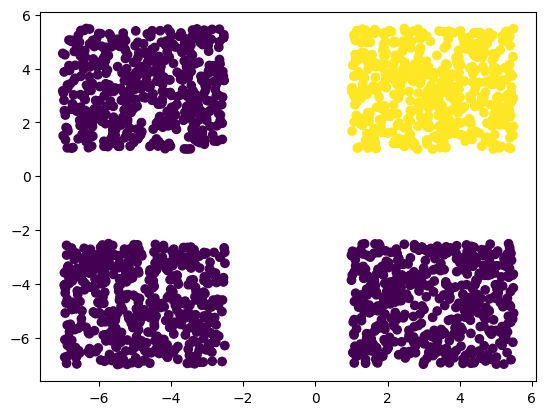

In [6]:
X_df = pd.read_csv('X.csv')
Y_df = pd.read_csv('Y.csv')

x = torch.from_numpy(X_df.to_numpy()).to(torch.float32)
y = torch.from_numpy(Y_df.to_numpy()).to(torch.float32)

plt.scatter(X_df['Column1'], X_df['Column2'], c=Y_df['Column1'])

In [7]:
list(zip(x, y))[0]

(tensor([5.3970e+00, 4.8492e+00]),
 tensor([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]))

## Init network

In [8]:
# Network for one-hot classification
in_dim = 2
h_dim = 32
out_dim = 4
model = nn.Sequential(
    nn.Linear(in_dim, h_dim),
    nn.Sigmoid(),
    nn.Linear(h_dim, out_dim)
)

### Import network

In [9]:
# Read nn weights from file
with open('nn.json') as fin:
    nn_json_str = fin.read()
    nn_json = json.loads(nn_json_str)
    
assert len(model.state_dict()) == 2 * len(nn_json)
iter_states = iter(model.state_dict())

for layer_json in nn_json:
    state_w = next(iter_states)
    state_b = next(iter_states)
    tensor_w = torch.tensor(layer_json['weight']).T.requires_grad_()
    tensor_b = torch.tensor(layer_json['bias']).T.requires_grad_()
    model.state_dict()[state_w].data.copy_(tensor_w)
    model.state_dict()[state_b].data.copy_(tensor_b)
    
ps = [model.state_dict()[layer].data for layer in model.state_dict()]
for p in ps:
    print(p.shape)

torch.Size([32, 2])
torch.Size([32])
torch.Size([4, 32])
torch.Size([4])


/tmp/ipykernel_25828/770732747.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  tensor_b = torch.tensor(layer_json['bias']).T.requires_grad_()


In [12]:
model.state_dict()['0.weight'].requires_grad

False

In [29]:
# y_hat = torch.argmax(torch.softmax(model.forward(x), dim=1), dim=1) + 1

In [11]:
yhat = torch.softmax(model(x), dim=1)

In [10]:
model(x)

tensor([[7.1357e+00, -9.9515e+00, 1.0094e+00, 7.6557e-01],
        [5.3387e+00, -8.3178e+00, -7.5079e-01, 2.2625e+00],
        [6.4243e+00, -9.1866e+00, 1.8113e+00, -8.2140e-02],
        ...,
        [-9.8644e-01, -2.5797e+00, -6.7602e+00, 7.3573e+00],
        [-1.8469e+00, -1.8805e+00, -7.9071e+00, 8.3706e+00],
        [-1.4871e+00, -2.2542e+00, -8.3071e+00, 8.7732e+00]],
       grad_fn=<AddmmBackward0>)

In [12]:
yhat

tensor([[9.9612e-01, 3.7793e-08, 2.1762e-03, 1.7052e-03],
        [9.5383e-01, 1.1183e-06, 2.1619e-03, 4.4003e-02],
        [9.8871e-01, 1.6420e-07, 9.8100e-03, 1.4769e-03],
        ...,
        [2.3782e-04, 4.8340e-05, 7.3913e-07, 9.9971e-01],
        [3.6522e-05, 3.5318e-05, 8.5246e-08, 9.9993e-01],
        [3.4993e-05, 1.6249e-05, 3.8204e-08, 9.9995e-01]],
       grad_fn=<SoftmaxBackward0>)

### Train network (if not imported)

In [25]:
data = list(zip(x, y))
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
epochs = 4
avg_loss = lambda data: torch.mean(torch.stack([loss_fn(model(x), y) for (x, y) in data]))
# show_every = epochs // 1
show_every = 1

for epoch in range(1, epochs+1):
    for (x_n, y_n) in data:
        assert len(x_n) == 2
        opt.zero_grad()
        loss = loss_fn(model(x_n), y_n)
        loss.backward()
        opt.step()
    if epoch % show_every == 0:
        print("Epoch ", epoch)
        print("Avg Loss: ", avg_loss(data).item())


Epoch  1
Avg Loss:  0.0
Epoch  2
Avg Loss:  0.0
Epoch  3
Avg Loss:  0.0
Epoch  4
Avg Loss:  0.0


In [27]:
yhat = model(x)

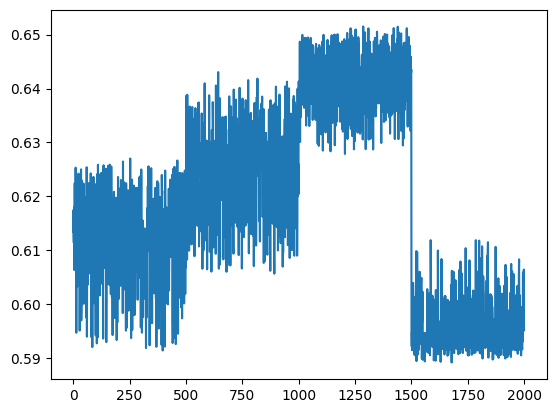

In [31]:
plt.plot(torch.special.expit(yhat).detach().numpy())

## LA: Emp. Fisher

In [29]:
from laplace.curvature import AsdlEF
la = Laplace(model, 'classification',
             subset_of_weights='all',
             hessian_structure='full', backend=AsdlEF)

la.fit(DataLoader(TensorDataset(x, y), batch_size=1))

print("zero?:", all(x == 0 for x in list(torch.flatten(la.H))))

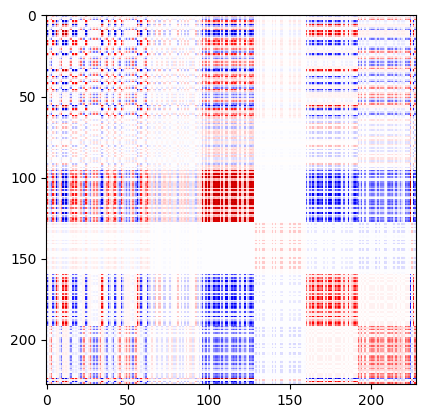

In [28]:
def colplot(H):
    lim = torch.max(torch.abs(la.H))
    plt.imshow(H, cmap='seismic', interpolation='nearest', clim=(-lim, +lim))
    plt.show()

colplot(la.H)

In [30]:
la.H

tensor([[1.3103e+00, 3.6680e-01, -4.8547e-02,  ..., 1.4349e-01, -1.2862e+00, -1.4872e-01],
        [3.6680e-01, 1.1980e-01, -1.5200e-02,  ..., 7.9928e-02, -3.8207e-01, -6.1792e-02],
        [-4.8547e-02, -1.5200e-02, 6.3717e-02,  ..., -3.3431e-02, 1.0695e-01, 2.4149e-01],
        ...,
        [1.4349e-01, 7.9928e-02, -3.3431e-02,  ..., 3.4709e-01, -1.3356e-01, -2.1331e-01],
        [-1.2862e+00, -3.8207e-01, 1.0695e-01,  ..., -1.3356e-01, 1.6164e+00, 1.5134e-01],
        [-1.4872e-01, -6.1792e-02, 2.4149e-01,  ..., -2.1331e-01, 1.5134e-01, 1.1614e+00]])

In [23]:
torch.min(la.H)

tensor(-1.6579e+00)

In [25]:
lim = torch.max(torch.abs(la.H)).item()

In [26]:
lim

2.7338387966156006

## Compute exact Hessian (sancheck)

In [ ]:
# too hard :/

## Compute emp. Fisher

In [10]:
from laplace.curvature.asdl import AsdlEF

In [36]:
def colplot(H):
    plt.imshow(H, cmap='seismic', interpolation='nearest')
    plt.show()

la = Laplace(model, 'classification',
             subset_of_weights='all',
             hessian_structure='full',
             backend=AsdlEF)

la.fit(DataLoader(TensorDataset(x, y), batch_size=2))

colplot(la.H)

In [ ]:
all(x == 0 for x in list(torch.flatten(la.H)))

True

In [38]:
1e-16 == 0

False

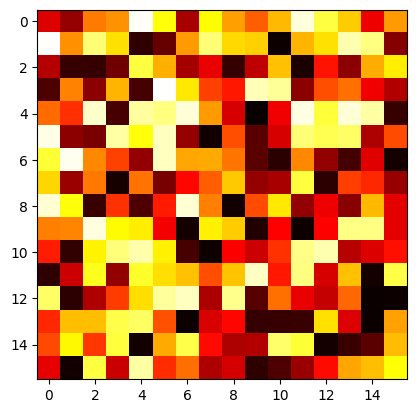

In [12]:
a = np.random.random((16, 16))
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

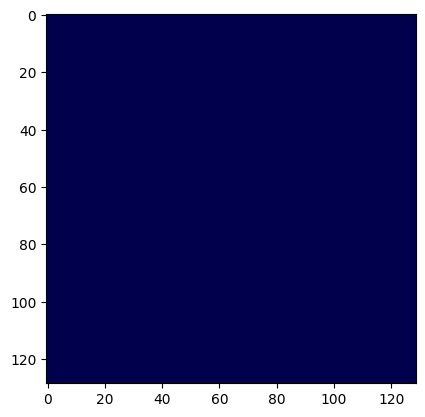

In [ ]:
la.H

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Compute KFAC Fisher